# 09 Hyper-parameter search for Deep Q Learning

#### 👉Deep RL is hard, because (among other things) it's very sensitivity to the hyper-parameters.

#### 👉We tune the hyper-parmeters following a trial&error approach:

![](../images/hparams_search_diagram.svg)

#### 👉However, Hyper-parameter spaces in deep RL problems are HUGE. A brute-force solution that would try all possible combinations of hyper-parameters is not feasible. We need something smarter than that...

#### 👉And this is when Bayesian search methods enther into the picture.

#### 👉In a nutshell, Bayesian search methods use past searches to inform promising avenues.

#### 👉 [Optuna](https://optuna.readthedocs.io/en/stable/index.html) is a Python open-source library that implements Bayesian search methods

<img src="https://github.com/Paulescu/hands-on-rl/blob/main/03_cart_pole/images/optuna.png?raw=True" width="400"/>

#### 👉Hyper-paramater search a piece of cake 🍰if you use Optuna.

In [3]:
%load_ext autoreload
%autoreload 2
%pylab inline
%config InlineBackend.figure_format = 'svg'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Environment 🌎

In [5]:
import gym
env = gym.make('CartPole-v1', render_mode = 'rgb_array')

### MLflow is a useful tool to track experiment results

cd to the root directory of this lesson (in my case `/Users/paulabartabajo/src/online-courses/hands-on-rl/03_cart_pole`) and spin up the mlflow tracking server as follows:

**$ mlflow server --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./artifacts --host 0.0.0.0 --port 5000**

### 💡 if you have another service listening to port 5000, increase port number by 1 until you hit a free port.

In [8]:
import mlflow

# connect mlflow client to the mlflow server that runs on localhost:5000
MLFLOW_SERVER_URI = 'http://localhost:5000'
mlflow.set_tracking_uri(str(MLFLOW_SERVER_URI))

EXPERIMENT_NAME = 'hyperparameter_search'
mlflow.set_experiment(EXPERIMENT_NAME)

2024/01/04 09:14:32 INFO mlflow.tracking.fluent: Experiment with name 'hyperparameter_search' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/372391382498284927', creation_time=1704370472026, experiment_id='372391382498284927', last_update_time=1704370472026, lifecycle_stage='active', name='hyperparameter_search', tags={}>

## Create an Optuna study

In [9]:
import optuna

from config import OPTUNA_DB

study = optuna.create_study(
    study_name=EXPERIMENT_NAME,
    direction='maximize',
    load_if_exists=True,
    storage=f'sqlite:///{OPTUNA_DB}'
)

c:\Users\Ploita\anaconda3\envs\HandsOnRL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-01-04 09:21:17,932] A new study created in RDB with name: hyperparameter_search


## Objective function we want to maximize

In [10]:
from optimize_hyperparameters import objective

# we define a lambda function because study.optimize()
# expect the objective function to have only 1 input
# (trial), while our objective function hast 2 extra
# inputs I defined to add flexibility to the script
func = lambda trial: objective(trial,
                               force_linear_model=False,
                               n_episodes_to_train=200)

## Set threshold to terminate hyperparameter search

In [11]:
class CheckHyperparamMeanRewardThreshold:
    def __init__(self, reward_threshold: float):
        self.reward_threshold = reward_threshold

    def __call__(self, study: optuna.study.Study, trial: optuna.trial.FrozenTrial) -> None:
        if trial.value >= self.reward_threshold:
            print((f'Stopping hyperparameter search because trial.value ({trial.value}) '
                   f'hit threshold ({self.reward_threshold})'))
            study.stop()

# Stop hyperparameter search when we hit a perfect mean reward of 500
hyperparam_search_stop_callback = CheckHyperparamMeanRewardThreshold(500.0)

## Let's start the search

In [13]:
study.optimize(func, n_trials=1000, callbacks=[hyperparam_search_stop_callback])

c:\Users\Ploita\Documents\GitHub\hands-on-rl\03_cart_pole\notebooks\optimize_hyperparameters.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
c:\Users\Ploita\anaconda3\envs\HandsOnRL\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 256] which is of type list.
  warnings.warn(message)
c:\Users\Ploita\Documents\GitHub\hands-on-rl\03_cart_pole\notebooks\optimize_hyperparameters.py:61: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  epsilon_end = trial.suggest_uniform("epsilon_en

67,586 parameters


100%|██████████| 200/200 [00:01<00:00, 152.94it/s]


Reward mean: 27.03, std: 12.68
Num steps mean: 27.03, std: 12.68


100%|██████████| 1000/1000 [00:07<00:00, 142.41it/s]
c:\Users\Ploita\anaconda3\envs\HandsOnRL\lib\site-packages\optuna\distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 256] which is of type list.
  warnings.warn(message)
[I 2024-01-04 09:24:13,523] Trial 1 finished with value: 29.647 and parameters: {'learning_rate': 3.1764919208731575e-05, 'discount_factor': 0.99, 'batch_size': 16, 'memory_size': 50000, 'freq_steps_train': 16, 'freq_steps_update_target': 1000, 'n_steps_warm_up_memory': 5000, 'n_gradient_steps': 4, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 10, 'normalize_state': False, 'epsilon_start': 0.9, 'epsilon_end': 0.16537499000237593, 'steps_epsilon_decay': 100000, 'seed': 216840073}. Best is trial 1 with value: 29.647.
c:\Users\Ploita\Documents\GitHub\hands-on-rl\03_cart_pole\notebooks\optimize_hyperparameters.py:22: FutureWarning: suggest_loguniform ha

67,586 parameters


100%|██████████| 200/200 [00:02<00:00, 82.67it/s]


Reward mean: 10.39, std: 0.86
Num steps mean: 10.39, std: 0.86


100%|██████████| 1000/1000 [00:02<00:00, 376.22it/s]
[I 2024-01-04 09:24:19,250] Trial 2 finished with value: 10.279 and parameters: {'learning_rate': 0.005163679689396554, 'discount_factor': 0.9, 'batch_size': 16, 'memory_size': 50000, 'freq_steps_train': 8, 'freq_steps_update_target': 100, 'n_steps_warm_up_memory': 1000, 'n_gradient_steps': 1, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 1, 'normalize_state': True, 'epsilon_start': 0.9, 'epsilon_end': 0.10939756832377122, 'steps_epsilon_decay': 1000, 'seed': 861621013}. Best is trial 1 with value: 29.647.


67,586 parameters


100%|██████████| 200/200 [00:06<00:00, 32.76it/s]


Reward mean: 9.56, std: 0.82
Num steps mean: 9.56, std: 0.82


100%|██████████| 1000/1000 [00:02<00:00, 388.45it/s]
[I 2024-01-04 09:24:28,503] Trial 3 finished with value: 9.372 and parameters: {'learning_rate': 2.3960522692194107e-05, 'discount_factor': 0.9, 'batch_size': 16, 'memory_size': 100000, 'freq_steps_train': 8, 'freq_steps_update_target': 100, 'n_steps_warm_up_memory': 1000, 'n_gradient_steps': 4, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 1, 'normalize_state': True, 'epsilon_start': 0.9, 'epsilon_end': 0.0865562420163326, 'steps_epsilon_decay': 100000, 'seed': 168906130}. Best is trial 1 with value: 29.647.


67,586 parameters


100%|██████████| 200/200 [00:02<00:00, 99.04it/s]


Reward mean: 9.60, std: 0.86
Num steps mean: 9.60, std: 0.86


100%|██████████| 1000/1000 [00:02<00:00, 431.73it/s]
[I 2024-01-04 09:24:33,197] Trial 4 finished with value: 9.426 and parameters: {'learning_rate': 0.0029854584638722976, 'discount_factor': 0.95, 'batch_size': 128, 'memory_size': 10000, 'freq_steps_train': 256, 'freq_steps_update_target': 10, 'n_steps_warm_up_memory': 1000, 'n_gradient_steps': 16, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 10, 'normalize_state': False, 'epsilon_start': 0.9, 'epsilon_end': 0.14705850075037896, 'steps_epsilon_decay': 1000, 'seed': 1021721580}. Best is trial 1 with value: 29.647.


67,586 parameters


100%|██████████| 200/200 [00:00<00:00, 209.97it/s]


Reward mean: 9.36, std: 0.76
Num steps mean: 9.36, std: 0.76


100%|██████████| 1000/1000 [00:02<00:00, 468.85it/s]
[I 2024-01-04 09:24:36,643] Trial 5 finished with value: 9.367 and parameters: {'learning_rate': 0.005804019543459466, 'discount_factor': 0.9, 'batch_size': 64, 'memory_size': 100000, 'freq_steps_train': 256, 'freq_steps_update_target': 1000, 'n_steps_warm_up_memory': 5000, 'n_gradient_steps': 1, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 1, 'normalize_state': False, 'epsilon_start': 0.9, 'epsilon_end': 0.1740289056992923, 'steps_epsilon_decay': 10000, 'seed': 710364089}. Best is trial 1 with value: 29.647.


67,586 parameters


100%|██████████| 200/200 [00:01<00:00, 120.22it/s]


Reward mean: 9.39, std: 0.76
Num steps mean: 9.39, std: 0.76


100%|██████████| 1000/1000 [00:02<00:00, 447.29it/s]
[I 2024-01-04 09:24:41,122] Trial 6 finished with value: 9.383 and parameters: {'learning_rate': 0.001050470590861527, 'discount_factor': 0.9, 'batch_size': 64, 'memory_size': 10000, 'freq_steps_train': 128, 'freq_steps_update_target': 10, 'n_steps_warm_up_memory': 1000, 'n_gradient_steps': 4, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 10, 'normalize_state': True, 'epsilon_start': 0.9, 'epsilon_end': 0.07005974274341596, 'steps_epsilon_decay': 1000, 'seed': 58155637}. Best is trial 1 with value: 29.647.


67,586 parameters


100%|██████████| 200/200 [00:01<00:00, 172.50it/s]


Reward mean: 9.32, std: 0.89
Num steps mean: 9.32, std: 0.89


100%|██████████| 1000/1000 [00:02<00:00, 457.96it/s]
[I 2024-01-04 09:24:44,849] Trial 7 finished with value: 9.349 and parameters: {'learning_rate': 1.2327485481047577e-05, 'discount_factor': 0.99, 'batch_size': 32, 'memory_size': 100000, 'freq_steps_train': 256, 'freq_steps_update_target': 10, 'n_steps_warm_up_memory': 1000, 'n_gradient_steps': 1, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 10, 'normalize_state': False, 'epsilon_start': 0.9, 'epsilon_end': 0.036188690377473125, 'steps_epsilon_decay': 10000, 'seed': 471455273}. Best is trial 1 with value: 29.647.


67,586 parameters


100%|██████████| 200/200 [00:02<00:00, 85.45it/s] 


Reward mean: 32.33, std: 7.67
Num steps mean: 32.33, std: 7.67


100%|██████████| 1000/1000 [00:07<00:00, 142.14it/s]
[I 2024-01-04 09:24:54,570] Trial 8 finished with value: 31.512 and parameters: {'learning_rate': 1.993580358171178e-05, 'discount_factor': 0.95, 'batch_size': 64, 'memory_size': 10000, 'freq_steps_train': 128, 'freq_steps_update_target': 100, 'n_steps_warm_up_memory': 5000, 'n_gradient_steps': 1, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 1, 'normalize_state': False, 'epsilon_start': 0.9, 'epsilon_end': 0.16101899729413693, 'steps_epsilon_decay': 1000, 'seed': 506854773}. Best is trial 8 with value: 31.512.


67,586 parameters


100%|██████████| 200/200 [00:30<00:00,  6.66it/s]


Reward mean: 210.17, std: 44.78
Num steps mean: 210.17, std: 44.78


100%|██████████| 1000/1000 [00:45<00:00, 22.19it/s]
[I 2024-01-04 09:26:10,066] Trial 9 finished with value: 215.785 and parameters: {'learning_rate': 0.0010792747100881138, 'discount_factor': 0.9, 'batch_size': 64, 'memory_size': 100000, 'freq_steps_train': 16, 'freq_steps_update_target': 10, 'n_steps_warm_up_memory': 1000, 'n_gradient_steps': 4, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 1, 'normalize_state': False, 'epsilon_start': 0.9, 'epsilon_end': 0.18470179225821848, 'steps_epsilon_decay': 10000, 'seed': 670990460}. Best is trial 9 with value: 215.785.


67,586 parameters


100%|██████████| 200/200 [00:01<00:00, 198.60it/s]


Reward mean: 9.43, std: 0.70
Num steps mean: 9.43, std: 0.70


100%|██████████| 1000/1000 [00:01<00:00, 505.88it/s]
[I 2024-01-04 09:26:13,383] Trial 10 finished with value: 9.38 and parameters: {'learning_rate': 0.0034216949532134408, 'discount_factor': 0.95, 'batch_size': 32, 'memory_size': 100000, 'freq_steps_train': 128, 'freq_steps_update_target': 1000, 'n_steps_warm_up_memory': 5000, 'n_gradient_steps': 16, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 10, 'normalize_state': False, 'epsilon_start': 0.9, 'epsilon_end': 0.13276294273493533, 'steps_epsilon_decay': 1000, 'seed': 377527027}. Best is trial 9 with value: 215.785.


67,586 parameters


100%|██████████| 200/200 [00:52<00:00,  3.82it/s]


Reward mean: 314.05, std: 149.23
Num steps mean: 314.05, std: 149.23


100%|██████████| 1000/1000 [01:14<00:00, 13.49it/s]
[I 2024-01-04 09:28:20,407] Trial 11 finished with value: 328.004 and parameters: {'learning_rate': 0.0002062527006608633, 'discount_factor': 0.9, 'batch_size': 128, 'memory_size': 100000, 'freq_steps_train': 16, 'freq_steps_update_target': 10, 'n_steps_warm_up_memory': 1000, 'n_gradient_steps': 4, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 1, 'normalize_state': True, 'epsilon_start': 0.9, 'epsilon_end': 0.005870675050397733, 'steps_epsilon_decay': 10000, 'seed': 662436985}. Best is trial 11 with value: 328.004.


67,586 parameters


100%|██████████| 200/200 [00:39<00:00,  5.10it/s]


Reward mean: 216.76, std: 29.95
Num steps mean: 216.76, std: 29.95


100%|██████████| 1000/1000 [00:47<00:00, 21.23it/s]
[I 2024-01-04 09:29:47,323] Trial 12 finished with value: 216.34 and parameters: {'learning_rate': 0.00017736651686366985, 'discount_factor': 0.9, 'batch_size': 128, 'memory_size': 100000, 'freq_steps_train': 16, 'freq_steps_update_target': 10, 'n_steps_warm_up_memory': 1000, 'n_gradient_steps': 4, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 1, 'normalize_state': True, 'epsilon_start': 0.9, 'epsilon_end': 0.007267712372105509, 'steps_epsilon_decay': 10000, 'seed': 703474809}. Best is trial 11 with value: 328.004.


67,586 parameters


100%|██████████| 200/200 [01:01<00:00,  3.24it/s]


Reward mean: 427.47, std: 109.20
Num steps mean: 427.47, std: 109.20


100%|██████████| 1000/1000 [01:37<00:00, 10.21it/s]
[I 2024-01-04 09:32:29,581] Trial 13 finished with value: 441.309 and parameters: {'learning_rate': 0.00013024923070528954, 'discount_factor': 0.9, 'batch_size': 128, 'memory_size': 100000, 'freq_steps_train': 16, 'freq_steps_update_target': 10, 'n_steps_warm_up_memory': 1000, 'n_gradient_steps': 4, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 1, 'normalize_state': True, 'epsilon_start': 0.9, 'epsilon_end': 0.008540610341255299, 'steps_epsilon_decay': 10000, 'seed': 731232761}. Best is trial 13 with value: 441.309.


67,586 parameters


100%|██████████| 200/200 [00:35<00:00,  5.67it/s]


Reward mean: 431.20, std: 76.07
Num steps mean: 431.20, std: 76.07


100%|██████████| 1000/1000 [01:36<00:00, 10.33it/s]
[I 2024-01-04 09:34:44,230] Trial 14 finished with value: 430.957 and parameters: {'learning_rate': 0.00011560113186394882, 'discount_factor': 0.9, 'batch_size': 128, 'memory_size': 100000, 'freq_steps_train': 16, 'freq_steps_update_target': 10, 'n_steps_warm_up_memory': 1000, 'n_gradient_steps': 4, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 1, 'normalize_state': True, 'epsilon_start': 0.9, 'epsilon_end': 0.00291719421339294, 'steps_epsilon_decay': 10000, 'seed': 896589246}. Best is trial 13 with value: 441.309.


67,586 parameters


100%|██████████| 200/200 [00:08<00:00, 23.92it/s]


Reward mean: 61.39, std: 21.82
Num steps mean: 61.39, std: 21.82


100%|██████████| 1000/1000 [00:12<00:00, 77.23it/s]
[I 2024-01-04 09:35:06,114] Trial 15 finished with value: 59.375 and parameters: {'learning_rate': 7.881687557230613e-05, 'discount_factor': 0.9, 'batch_size': 128, 'memory_size': 100000, 'freq_steps_train': 16, 'freq_steps_update_target': 10, 'n_steps_warm_up_memory': 1000, 'n_gradient_steps': 4, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 1, 'normalize_state': True, 'epsilon_start': 0.9, 'epsilon_end': 0.04446703002719754, 'steps_epsilon_decay': 10000, 'seed': 1021401931}. Best is trial 13 with value: 441.309.


67,586 parameters


100%|██████████| 200/200 [00:07<00:00, 27.70it/s]


Reward mean: 9.47, std: 0.74
Num steps mean: 9.47, std: 0.74


100%|██████████| 1000/1000 [00:03<00:00, 327.69it/s]
[I 2024-01-04 09:35:16,998] Trial 16 finished with value: 9.344 and parameters: {'learning_rate': 7.19278261835675e-05, 'discount_factor': 0.99, 'batch_size': 128, 'memory_size': 50000, 'freq_steps_train': 16, 'freq_steps_update_target': 10, 'n_steps_warm_up_memory': 1000, 'n_gradient_steps': 4, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 1, 'normalize_state': True, 'epsilon_start': 0.9, 'epsilon_end': 0.03829323185892191, 'steps_epsilon_decay': 10000, 'seed': 869089944}. Best is trial 13 with value: 441.309.


67,586 parameters


100%|██████████| 200/200 [01:24<00:00,  2.37it/s]


Reward mean: 262.00, std: 125.36
Num steps mean: 262.00, std: 125.36


100%|██████████| 1000/1000 [00:56<00:00, 17.75it/s]
[I 2024-01-04 09:37:40,419] Trial 17 finished with value: 248.608 and parameters: {'learning_rate': 0.0005681011650895452, 'discount_factor': 0.9, 'batch_size': 128, 'memory_size': 100000, 'freq_steps_train': 16, 'freq_steps_update_target': 10, 'n_steps_warm_up_memory': 1000, 'n_gradient_steps': 16, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 1, 'normalize_state': True, 'epsilon_start': 0.9, 'epsilon_end': 0.06147956914068287, 'steps_epsilon_decay': 10000, 'seed': 871787757}. Best is trial 13 with value: 441.309.


67,586 parameters


100%|██████████| 200/200 [00:08<00:00, 23.86it/s]


Reward mean: 43.14, std: 20.11
Num steps mean: 43.14, std: 20.11


100%|██████████| 1000/1000 [00:09<00:00, 104.37it/s]
[I 2024-01-04 09:37:58,959] Trial 18 finished with value: 43.536 and parameters: {'learning_rate': 7.937023376509404e-05, 'discount_factor': 0.9, 'batch_size': 128, 'memory_size': 100000, 'freq_steps_train': 16, 'freq_steps_update_target': 10, 'n_steps_warm_up_memory': 1000, 'n_gradient_steps': 4, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 1, 'normalize_state': True, 'epsilon_start': 0.9, 'epsilon_end': 0.018675338790243322, 'steps_epsilon_decay': 100000, 'seed': 844739460}. Best is trial 13 with value: 441.309.


67,586 parameters


100%|██████████| 200/200 [00:00<00:00, 216.44it/s]


Reward mean: 9.35, std: 0.79
Num steps mean: 9.35, std: 0.79


100%|██████████| 1000/1000 [00:02<00:00, 440.37it/s]
[I 2024-01-04 09:38:02,716] Trial 19 finished with value: 9.352 and parameters: {'learning_rate': 0.00037486436503445853, 'discount_factor': 0.99, 'batch_size': 128, 'memory_size': 50000, 'freq_steps_train': 8, 'freq_steps_update_target': 1000, 'n_steps_warm_up_memory': 5000, 'n_gradient_steps': 4, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 1, 'normalize_state': True, 'epsilon_start': 0.9, 'epsilon_end': 0.10984611115950696, 'steps_epsilon_decay': 10000, 'seed': 1065777907}. Best is trial 13 with value: 441.309.


67,586 parameters


100%|██████████| 200/200 [01:02<00:00,  3.20it/s]


Reward mean: 139.30, std: 16.61
Num steps mean: 139.30, std: 16.61


100%|██████████| 1000/1000 [00:30<00:00, 32.26it/s]
[I 2024-01-04 09:39:36,786] Trial 20 finished with value: 139.985 and parameters: {'learning_rate': 0.00015154329912102222, 'discount_factor': 0.95, 'batch_size': 32, 'memory_size': 10000, 'freq_steps_train': 16, 'freq_steps_update_target': 100, 'n_steps_warm_up_memory': 1000, 'n_gradient_steps': 16, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 1, 'normalize_state': True, 'epsilon_start': 0.9, 'epsilon_end': 0.025267886150423927, 'steps_epsilon_decay': 10000, 'seed': 590075983}. Best is trial 13 with value: 441.309.


67,586 parameters


100%|██████████| 200/200 [00:07<00:00, 26.65it/s]


Reward mean: 9.44, std: 0.86
Num steps mean: 9.44, std: 0.86


100%|██████████| 1000/1000 [00:02<00:00, 455.93it/s]
[I 2024-01-04 09:39:47,089] Trial 21 finished with value: 9.329 and parameters: {'learning_rate': 4.7220612336818334e-05, 'discount_factor': 0.9, 'batch_size': 128, 'memory_size': 100000, 'freq_steps_train': 16, 'freq_steps_update_target': 10, 'n_steps_warm_up_memory': 1000, 'n_gradient_steps': 4, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 1, 'normalize_state': True, 'epsilon_start': 0.9, 'epsilon_end': 0.05876473137090239, 'steps_epsilon_decay': 100000, 'seed': 775500659}. Best is trial 13 with value: 441.309.


67,586 parameters


100%|██████████| 200/200 [00:57<00:00,  3.48it/s]


Reward mean: 262.62, std: 55.63
Num steps mean: 262.62, std: 55.63


100%|██████████| 1000/1000 [01:25<00:00, 11.69it/s]
[I 2024-01-04 09:42:12,800] Trial 22 finished with value: 259.777 and parameters: {'learning_rate': 0.00021970651620588935, 'discount_factor': 0.9, 'batch_size': 128, 'memory_size': 100000, 'freq_steps_train': 16, 'freq_steps_update_target': 10, 'n_steps_warm_up_memory': 1000, 'n_gradient_steps': 4, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 1, 'normalize_state': True, 'epsilon_start': 0.9, 'epsilon_end': 0.0023421864744907414, 'steps_epsilon_decay': 10000, 'seed': 631397286}. Best is trial 13 with value: 441.309.


67,586 parameters


100%|██████████| 200/200 [00:34<00:00,  5.73it/s]


Reward mean: 181.11, std: 15.02
Num steps mean: 181.11, std: 15.02


100%|██████████| 1000/1000 [01:00<00:00, 16.49it/s]
[I 2024-01-04 09:43:49,215] Trial 23 finished with value: 185.283 and parameters: {'learning_rate': 0.00013568249880359834, 'discount_factor': 0.9, 'batch_size': 128, 'memory_size': 100000, 'freq_steps_train': 16, 'freq_steps_update_target': 10, 'n_steps_warm_up_memory': 1000, 'n_gradient_steps': 4, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 1, 'normalize_state': True, 'epsilon_start': 0.9, 'epsilon_end': 0.00036996991641135863, 'steps_epsilon_decay': 10000, 'seed': 927218856}. Best is trial 13 with value: 441.309.


67,586 parameters


100%|██████████| 200/200 [01:35<00:00,  2.08it/s]


Reward mean: 259.89, std: 76.00
Num steps mean: 259.89, std: 76.00


100%|██████████| 1000/1000 [02:10<00:00,  7.65it/s]
[I 2024-01-04 09:47:38,984] Trial 24 finished with value: 267.305 and parameters: {'learning_rate': 0.000487906771451841, 'discount_factor': 0.9, 'batch_size': 128, 'memory_size': 100000, 'freq_steps_train': 16, 'freq_steps_update_target': 10, 'n_steps_warm_up_memory': 1000, 'n_gradient_steps': 4, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 1, 'normalize_state': True, 'epsilon_start': 0.9, 'epsilon_end': 0.022096550002574294, 'steps_epsilon_decay': 10000, 'seed': 423891254}. Best is trial 13 with value: 441.309.


67,586 parameters


100%|██████████| 200/200 [01:33<00:00,  2.14it/s]


Reward mean: 188.58, std: 57.07
Num steps mean: 188.58, std: 57.07


100%|██████████| 1000/1000 [01:25<00:00, 11.73it/s]
[I 2024-01-04 09:50:41,255] Trial 25 finished with value: 188.045 and parameters: {'learning_rate': 0.00028810311434594466, 'discount_factor': 0.9, 'batch_size': 128, 'memory_size': 100000, 'freq_steps_train': 16, 'freq_steps_update_target': 10, 'n_steps_warm_up_memory': 1000, 'n_gradient_steps': 4, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 1, 'normalize_state': True, 'epsilon_start': 0.9, 'epsilon_end': 0.01770823445306894, 'steps_epsilon_decay': 10000, 'seed': 781340614}. Best is trial 13 with value: 441.309.


67,586 parameters


100%|██████████| 200/200 [03:05<00:00,  1.08it/s]


Reward mean: 449.32, std: 88.03
Num steps mean: 449.32, std: 88.03


100%|██████████| 1000/1000 [03:49<00:00,  4.36it/s]
[I 2024-01-04 09:57:39,604] Trial 26 finished with value: 478.654 and parameters: {'learning_rate': 0.0008453622125282605, 'discount_factor': 0.9, 'batch_size': 128, 'memory_size': 100000, 'freq_steps_train': 16, 'freq_steps_update_target': 10, 'n_steps_warm_up_memory': 1000, 'n_gradient_steps': 4, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 1, 'normalize_state': True, 'epsilon_start': 0.9, 'epsilon_end': 0.04596223340145325, 'steps_epsilon_decay': 10000, 'seed': 586413845}. Best is trial 26 with value: 478.654.


67,586 parameters


100%|██████████| 200/200 [00:01<00:00, 120.89it/s]


Reward mean: 15.06, std: 1.18
Num steps mean: 15.06, std: 1.18


100%|██████████| 1000/1000 [00:07<00:00, 127.41it/s]
[I 2024-01-04 09:57:50,180] Trial 27 finished with value: 15.215 and parameters: {'learning_rate': 0.0008912610078750077, 'discount_factor': 0.9, 'batch_size': 128, 'memory_size': 100000, 'freq_steps_train': 8, 'freq_steps_update_target': 10, 'n_steps_warm_up_memory': 5000, 'n_gradient_steps': 4, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 10, 'normalize_state': True, 'epsilon_start': 0.9, 'epsilon_end': 0.050519530975243435, 'steps_epsilon_decay': 10000, 'seed': 558736222}. Best is trial 26 with value: 478.654.


67,586 parameters


100%|██████████| 200/200 [00:02<00:00, 73.14it/s]


Reward mean: 9.86, std: 0.51
Num steps mean: 9.86, std: 0.51


100%|██████████| 1000/1000 [00:04<00:00, 234.45it/s]
[I 2024-01-04 09:57:58,501] Trial 28 finished with value: 9.913 and parameters: {'learning_rate': 0.0018337273569343495, 'discount_factor': 0.9, 'batch_size': 32, 'memory_size': 100000, 'freq_steps_train': 256, 'freq_steps_update_target': 10, 'n_steps_warm_up_memory': 1000, 'n_gradient_steps': 4, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 1, 'normalize_state': True, 'epsilon_start': 0.9, 'epsilon_end': 0.07632006857763195, 'steps_epsilon_decay': 10000, 'seed': 368637326}. Best is trial 26 with value: 478.654.


67,586 parameters


100%|██████████| 200/200 [00:04<00:00, 46.74it/s]


Reward mean: 9.40, std: 0.68
Num steps mean: 9.40, std: 0.68


100%|██████████| 1000/1000 [00:03<00:00, 275.21it/s]
[I 2024-01-04 09:58:07,679] Trial 29 finished with value: 9.337 and parameters: {'learning_rate': 0.00011742391009786517, 'discount_factor': 0.99, 'batch_size': 16, 'memory_size': 50000, 'freq_steps_train': 128, 'freq_steps_update_target': 1000, 'n_steps_warm_up_memory': 1000, 'n_gradient_steps': 16, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 1, 'normalize_state': True, 'epsilon_start': 0.9, 'epsilon_end': 0.03391772335702131, 'steps_epsilon_decay': 100000, 'seed': 949875774}. Best is trial 26 with value: 478.654.


67,586 parameters


100%|██████████| 200/200 [00:01<00:00, 146.80it/s]


Reward mean: 9.36, std: 0.88
Num steps mean: 9.36, std: 0.88


100%|██████████| 1000/1000 [00:02<00:00, 351.01it/s]
[I 2024-01-04 09:58:12,963] Trial 30 finished with value: 9.376 and parameters: {'learning_rate': 3.705845737135342e-05, 'discount_factor': 0.95, 'batch_size': 16, 'memory_size': 10000, 'freq_steps_train': 16, 'freq_steps_update_target': 100, 'n_steps_warm_up_memory': 5000, 'n_gradient_steps': 1, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 10, 'normalize_state': True, 'epsilon_start': 0.9, 'epsilon_end': 0.09811201062280892, 'steps_epsilon_decay': 10000, 'seed': 260347546}. Best is trial 26 with value: 478.654.


67,586 parameters


100%|██████████| 200/200 [00:12<00:00, 15.75it/s]


Reward mean: 9.48, std: 0.77
Num steps mean: 9.48, std: 0.77


100%|██████████| 1000/1000 [00:03<00:00, 295.69it/s]
[I 2024-01-04 09:58:30,077] Trial 31 finished with value: 9.354 and parameters: {'learning_rate': 0.009664674167416178, 'discount_factor': 0.99, 'batch_size': 128, 'memory_size': 50000, 'freq_steps_train': 16, 'freq_steps_update_target': 1000, 'n_steps_warm_up_memory': 1000, 'n_gradient_steps': 4, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 1, 'normalize_state': True, 'epsilon_start': 0.9, 'epsilon_end': 0.05232719300777089, 'steps_epsilon_decay': 100000, 'seed': 747985117}. Best is trial 26 with value: 478.654.


67,586 parameters


100%|██████████| 200/200 [01:48<00:00,  1.84it/s]


Reward mean: 264.12, std: 30.92
Num steps mean: 264.12, std: 30.92


100%|██████████| 1000/1000 [01:56<00:00,  8.61it/s]
[I 2024-01-04 10:02:17,934] Trial 32 finished with value: 261.423 and parameters: {'learning_rate': 0.00026841016421595037, 'discount_factor': 0.9, 'batch_size': 128, 'memory_size': 100000, 'freq_steps_train': 16, 'freq_steps_update_target': 10, 'n_steps_warm_up_memory': 1000, 'n_gradient_steps': 4, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 1, 'normalize_state': True, 'epsilon_start': 0.9, 'epsilon_end': 0.006835962619893904, 'steps_epsilon_decay': 10000, 'seed': 601332622}. Best is trial 26 with value: 478.654.


67,586 parameters


100%|██████████| 200/200 [02:50<00:00,  1.17it/s]


Reward mean: 458.17, std: 71.53
Num steps mean: 458.17, std: 71.53


100%|██████████| 1000/1000 [03:48<00:00,  4.38it/s]
[I 2024-01-04 10:09:00,667] Trial 33 finished with value: 454.443 and parameters: {'learning_rate': 0.0005224993821016904, 'discount_factor': 0.9, 'batch_size': 128, 'memory_size': 100000, 'freq_steps_train': 16, 'freq_steps_update_target': 10, 'n_steps_warm_up_memory': 1000, 'n_gradient_steps': 4, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 1, 'normalize_state': True, 'epsilon_start': 0.9, 'epsilon_end': 0.015525414894860787, 'steps_epsilon_decay': 10000, 'seed': 658126516}. Best is trial 26 with value: 478.654.


67,586 parameters


100%|██████████| 200/200 [01:56<00:00,  1.71it/s]


Reward mean: 107.83, std: 3.24
Num steps mean: 107.83, std: 3.24


100%|██████████| 1000/1000 [00:55<00:00, 17.87it/s]
[I 2024-01-04 10:11:56,883] Trial 34 finished with value: 108.339 and parameters: {'learning_rate': 0.000603945635532587, 'discount_factor': 0.9, 'batch_size': 128, 'memory_size': 100000, 'freq_steps_train': 16, 'freq_steps_update_target': 10, 'n_steps_warm_up_memory': 1000, 'n_gradient_steps': 4, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 1, 'normalize_state': True, 'epsilon_start': 0.9, 'epsilon_end': 0.022548906587646203, 'steps_epsilon_decay': 10000, 'seed': 808675979}. Best is trial 26 with value: 478.654.


67,586 parameters


100%|██████████| 200/200 [01:25<00:00,  2.35it/s]


Reward mean: 103.94, std: 3.80
Num steps mean: 103.94, std: 3.80


100%|██████████| 1000/1000 [00:49<00:00, 20.29it/s]
[I 2024-01-04 10:14:14,942] Trial 35 finished with value: 103.847 and parameters: {'learning_rate': 0.0013868353355669832, 'discount_factor': 0.9, 'batch_size': 16, 'memory_size': 100000, 'freq_steps_train': 8, 'freq_steps_update_target': 10, 'n_steps_warm_up_memory': 1000, 'n_gradient_steps': 4, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 1, 'normalize_state': True, 'epsilon_start': 0.9, 'epsilon_end': 0.029696979133595702, 'steps_epsilon_decay': 10000, 'seed': 518841226}. Best is trial 26 with value: 478.654.


67,586 parameters


100%|██████████| 200/200 [00:09<00:00, 22.18it/s]


Reward mean: 9.50, std: 0.78
Num steps mean: 9.50, std: 0.78


100%|██████████| 1000/1000 [00:05<00:00, 194.81it/s]
[I 2024-01-04 10:14:30,310] Trial 36 finished with value: 9.339 and parameters: {'learning_rate': 0.00042737559219285613, 'discount_factor': 0.9, 'batch_size': 128, 'memory_size': 100000, 'freq_steps_train': 16, 'freq_steps_update_target': 100, 'n_steps_warm_up_memory': 1000, 'n_gradient_steps': 4, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 1, 'normalize_state': True, 'epsilon_start': 0.9, 'epsilon_end': 0.014611592087970662, 'steps_epsilon_decay': 1000, 'seed': 947645851}. Best is trial 26 with value: 478.654.


67,586 parameters


100%|██████████| 200/200 [00:02<00:00, 77.18it/s] 


Reward mean: 9.45, std: 0.80
Num steps mean: 9.45, std: 0.80


100%|██████████| 1000/1000 [00:05<00:00, 196.82it/s]
[I 2024-01-04 10:14:38,991] Trial 37 finished with value: 9.359 and parameters: {'learning_rate': 0.0007380570113086566, 'discount_factor': 0.9, 'batch_size': 128, 'memory_size': 100000, 'freq_steps_train': 256, 'freq_steps_update_target': 10, 'n_steps_warm_up_memory': 1000, 'n_gradient_steps': 1, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 1, 'normalize_state': False, 'epsilon_start': 0.9, 'epsilon_end': 0.04294311201233621, 'steps_epsilon_decay': 10000, 'seed': 730983322}. Best is trial 26 with value: 478.654.


67,586 parameters


100%|██████████| 200/200 [01:07<00:00,  2.95it/s]


Reward mean: 101.17, std: 2.13
Num steps mean: 101.17, std: 2.13


100%|██████████| 1000/1000 [01:02<00:00, 15.91it/s]
[I 2024-01-04 10:16:51,301] Trial 38 finished with value: 101.496 and parameters: {'learning_rate': 0.001915753106570744, 'discount_factor': 0.9, 'batch_size': 64, 'memory_size': 10000, 'freq_steps_train': 16, 'freq_steps_update_target': 10, 'n_steps_warm_up_memory': 1000, 'n_gradient_steps': 4, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 10, 'normalize_state': True, 'epsilon_start': 0.9, 'epsilon_end': 0.07772078819255085, 'steps_epsilon_decay': 10000, 'seed': 620817558}. Best is trial 26 with value: 478.654.


67,586 parameters


100%|██████████| 200/200 [00:03<00:00, 64.03it/s]


Reward mean: 9.53, std: 0.79
Num steps mean: 9.53, std: 0.79


100%|██████████| 1000/1000 [00:08<00:00, 124.05it/s]
[I 2024-01-04 10:17:04,212] Trial 39 finished with value: 9.37 and parameters: {'learning_rate': 5.5567383811781326e-05, 'discount_factor': 0.9, 'batch_size': 16, 'memory_size': 50000, 'freq_steps_train': 128, 'freq_steps_update_target': 10, 'n_steps_warm_up_memory': 5000, 'n_gradient_steps': 1, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 1, 'normalize_state': True, 'epsilon_start': 0.9, 'epsilon_end': 0.013478877012571031, 'steps_epsilon_decay': 1000, 'seed': 459942411}. Best is trial 26 with value: 478.654.


67,586 parameters


100%|██████████| 200/200 [00:37<00:00,  5.28it/s]


Reward mean: 9.36, std: 0.81
Num steps mean: 9.36, std: 0.81


100%|██████████| 1000/1000 [00:07<00:00, 141.58it/s]
[I 2024-01-04 10:17:50,501] Trial 40 finished with value: 9.36 and parameters: {'learning_rate': 2.5461809527955167e-05, 'discount_factor': 0.95, 'batch_size': 128, 'memory_size': 100000, 'freq_steps_train': 8, 'freq_steps_update_target': 100, 'n_steps_warm_up_memory': 1000, 'n_gradient_steps': 4, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 10, 'normalize_state': False, 'epsilon_start': 0.9, 'epsilon_end': 0.03122041426638364, 'steps_epsilon_decay': 100000, 'seed': 296555659}. Best is trial 26 with value: 478.654.


67,586 parameters


100%|██████████| 200/200 [00:04<00:00, 42.31it/s]


Reward mean: 9.56, std: 0.96
Num steps mean: 9.56, std: 0.96


100%|██████████| 1000/1000 [00:03<00:00, 285.79it/s]
[I 2024-01-04 10:17:59,864] Trial 41 finished with value: 9.423 and parameters: {'learning_rate': 0.00010288452242902013, 'discount_factor': 0.9, 'batch_size': 64, 'memory_size': 100000, 'freq_steps_train': 256, 'freq_steps_update_target': 1000, 'n_steps_warm_up_memory': 1000, 'n_gradient_steps': 16, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 1, 'normalize_state': False, 'epsilon_start': 0.9, 'epsilon_end': 0.09243399209289885, 'steps_epsilon_decay': 10000, 'seed': 45759395}. Best is trial 26 with value: 478.654.


67,586 parameters


100%|██████████| 200/200 [02:39<00:00,  1.25it/s]


Reward mean: 384.28, std: 96.08
Num steps mean: 384.28, std: 96.08


100%|██████████| 1000/1000 [02:56<00:00,  5.67it/s]
[I 2024-01-04 10:23:39,388] Trial 42 finished with value: 389.996 and parameters: {'learning_rate': 0.00019656072073802376, 'discount_factor': 0.9, 'batch_size': 128, 'memory_size': 100000, 'freq_steps_train': 16, 'freq_steps_update_target': 10, 'n_steps_warm_up_memory': 1000, 'n_gradient_steps': 4, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 1, 'normalize_state': True, 'epsilon_start': 0.9, 'epsilon_end': 0.010055999096143435, 'steps_epsilon_decay': 10000, 'seed': 680272727}. Best is trial 26 with value: 478.654.


67,586 parameters


100%|██████████| 200/200 [01:33<00:00,  2.14it/s]


Reward mean: 500.00, std: 0.00
Num steps mean: 500.00, std: 0.00


100%|██████████| 1000/1000 [02:22<00:00,  7.02it/s]
[I 2024-01-04 10:27:38,721] Trial 43 finished with value: 499.692 and parameters: {'learning_rate': 0.000350479345193672, 'discount_factor': 0.9, 'batch_size': 128, 'memory_size': 100000, 'freq_steps_train': 16, 'freq_steps_update_target': 10, 'n_steps_warm_up_memory': 1000, 'n_gradient_steps': 4, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 1, 'normalize_state': True, 'epsilon_start': 0.9, 'epsilon_end': 0.012238914745229198, 'steps_epsilon_decay': 10000, 'seed': 679251580}. Best is trial 43 with value: 499.692.


67,586 parameters


100%|██████████| 200/200 [00:57<00:00,  3.46it/s]


Reward mean: 130.49, std: 31.40
Num steps mean: 130.49, std: 31.40


100%|██████████| 1000/1000 [00:41<00:00, 24.10it/s]
[I 2024-01-04 10:29:18,680] Trial 44 finished with value: 130.153 and parameters: {'learning_rate': 0.00036009023091829146, 'discount_factor': 0.9, 'batch_size': 128, 'memory_size': 100000, 'freq_steps_train': 16, 'freq_steps_update_target': 10, 'n_steps_warm_up_memory': 1000, 'n_gradient_steps': 4, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 1, 'normalize_state': True, 'epsilon_start': 0.9, 'epsilon_end': 0.028249665605553365, 'steps_epsilon_decay': 10000, 'seed': 555319435}. Best is trial 43 with value: 499.692.


67,586 parameters


100%|██████████| 200/200 [00:28<00:00,  7.01it/s]


Reward mean: 121.45, std: 3.03
Num steps mean: 121.45, std: 3.03


100%|██████████| 1000/1000 [00:37<00:00, 26.62it/s]
[I 2024-01-04 10:30:25,572] Trial 45 finished with value: 121.58 and parameters: {'learning_rate': 0.0007108929031568098, 'discount_factor': 0.9, 'batch_size': 32, 'memory_size': 100000, 'freq_steps_train': 16, 'freq_steps_update_target': 10, 'n_steps_warm_up_memory': 1000, 'n_gradient_steps': 4, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 1, 'normalize_state': True, 'epsilon_start': 0.9, 'epsilon_end': 0.1174263361330768, 'steps_epsilon_decay': 10000, 'seed': 811303055}. Best is trial 43 with value: 499.692.


67,586 parameters


100%|██████████| 200/200 [00:05<00:00, 38.62it/s]


Reward mean: 13.03, std: 6.59
Num steps mean: 13.03, std: 6.59


100%|██████████| 1000/1000 [00:04<00:00, 237.16it/s]
[I 2024-01-04 10:30:35,746] Trial 46 finished with value: 12.558 and parameters: {'learning_rate': 0.0002684198501687024, 'discount_factor': 0.9, 'batch_size': 128, 'memory_size': 100000, 'freq_steps_train': 16, 'freq_steps_update_target': 10, 'n_steps_warm_up_memory': 1000, 'n_gradient_steps': 4, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 1, 'normalize_state': True, 'epsilon_start': 0.9, 'epsilon_end': 0.0014805476395604467, 'steps_epsilon_decay': 1000, 'seed': 648904365}. Best is trial 43 with value: 499.692.


67,586 parameters


100%|██████████| 200/200 [00:01<00:00, 137.96it/s]


Reward mean: 9.62, std: 1.53
Num steps mean: 9.62, std: 1.53


100%|██████████| 1000/1000 [00:03<00:00, 320.54it/s]
[I 2024-01-04 10:30:41,152] Trial 47 finished with value: 9.742 and parameters: {'learning_rate': 0.0012973687496300307, 'discount_factor': 0.9, 'batch_size': 128, 'memory_size': 10000, 'freq_steps_train': 128, 'freq_steps_update_target': 10, 'n_steps_warm_up_memory': 5000, 'n_gradient_steps': 4, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 1, 'normalize_state': True, 'epsilon_start': 0.9, 'epsilon_end': 0.0396175427860838, 'steps_epsilon_decay': 10000, 'seed': 704373049}. Best is trial 43 with value: 499.692.


67,586 parameters


100%|██████████| 200/200 [00:03<00:00, 59.14it/s]


Reward mean: 9.37, std: 0.76
Num steps mean: 9.37, std: 0.76


100%|██████████| 1000/1000 [00:02<00:00, 343.32it/s]
[I 2024-01-04 10:30:47,972] Trial 48 finished with value: 9.387 and parameters: {'learning_rate': 1.4304644172070786e-05, 'discount_factor': 0.95, 'batch_size': 128, 'memory_size': 100000, 'freq_steps_train': 16, 'freq_steps_update_target': 10, 'n_steps_warm_up_memory': 1000, 'n_gradient_steps': 1, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 1, 'normalize_state': False, 'epsilon_start': 0.9, 'epsilon_end': 0.013472159391641064, 'steps_epsilon_decay': 10000, 'seed': 892223543}. Best is trial 43 with value: 499.692.


67,586 parameters


100%|██████████| 200/200 [00:07<00:00, 25.19it/s]


Reward mean: 9.55, std: 1.82
Num steps mean: 9.55, std: 1.82


100%|██████████| 1000/1000 [00:02<00:00, 344.45it/s]
[I 2024-01-04 10:30:59,629] Trial 49 finished with value: 9.443 and parameters: {'learning_rate': 0.00010254023386562762, 'discount_factor': 0.99, 'batch_size': 64, 'memory_size': 100000, 'freq_steps_train': 16, 'freq_steps_update_target': 10, 'n_steps_warm_up_memory': 1000, 'n_gradient_steps': 4, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 10, 'normalize_state': True, 'epsilon_start': 0.9, 'epsilon_end': 0.19449597496913307, 'steps_epsilon_decay': 10000, 'seed': 736648495}. Best is trial 43 with value: 499.692.


67,586 parameters


100%|██████████| 200/200 [00:33<00:00,  5.95it/s]


Reward mean: 89.31, std: 16.90
Num steps mean: 89.31, std: 16.90


100%|██████████| 1000/1000 [00:29<00:00, 33.90it/s]
[I 2024-01-04 10:32:03,629] Trial 50 finished with value: 92.811 and parameters: {'learning_rate': 0.004231259545005181, 'discount_factor': 0.9, 'batch_size': 128, 'memory_size': 100000, 'freq_steps_train': 16, 'freq_steps_update_target': 10, 'n_steps_warm_up_memory': 1000, 'n_gradient_steps': 4, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 1, 'normalize_state': True, 'epsilon_start': 0.9, 'epsilon_end': 0.05351101928695719, 'steps_epsilon_decay': 10000, 'seed': 501916497}. Best is trial 43 with value: 499.692.


67,586 parameters


100%|██████████| 200/200 [00:02<00:00, 99.13it/s]


Reward mean: 9.42, std: 0.86
Num steps mean: 9.42, std: 0.86


100%|██████████| 1000/1000 [00:03<00:00, 302.97it/s]
[I 2024-01-04 10:32:09,778] Trial 51 finished with value: 9.355 and parameters: {'learning_rate': 0.002279478415061963, 'discount_factor': 0.9, 'batch_size': 32, 'memory_size': 100000, 'freq_steps_train': 256, 'freq_steps_update_target': 100, 'n_steps_warm_up_memory': 1000, 'n_gradient_steps': 16, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 1, 'normalize_state': True, 'epsilon_start': 0.9, 'epsilon_end': 0.06594834081377016, 'steps_epsilon_decay': 1000, 'seed': 574099070}. Best is trial 43 with value: 499.692.


67,586 parameters


100%|██████████| 200/200 [01:10<00:00,  2.84it/s]


Reward mean: 195.31, std: 115.14
Num steps mean: 195.31, std: 115.14


100%|██████████| 1000/1000 [01:02<00:00, 15.90it/s]
[I 2024-01-04 10:34:26,037] Trial 52 finished with value: 199.06 and parameters: {'learning_rate': 0.00019513115824291806, 'discount_factor': 0.9, 'batch_size': 128, 'memory_size': 100000, 'freq_steps_train': 16, 'freq_steps_update_target': 10, 'n_steps_warm_up_memory': 1000, 'n_gradient_steps': 4, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 1, 'normalize_state': True, 'epsilon_start': 0.9, 'epsilon_end': 0.011929060478644934, 'steps_epsilon_decay': 10000, 'seed': 677639659}. Best is trial 43 with value: 499.692.


67,586 parameters


100%|██████████| 200/200 [01:00<00:00,  3.33it/s]


Reward mean: 288.48, std: 35.40
Num steps mean: 288.48, std: 35.40


100%|██████████| 1000/1000 [01:37<00:00, 10.30it/s]
[I 2024-01-04 10:37:06,162] Trial 53 finished with value: 289.131 and parameters: {'learning_rate': 0.00014639609124253105, 'discount_factor': 0.9, 'batch_size': 128, 'memory_size': 100000, 'freq_steps_train': 16, 'freq_steps_update_target': 10, 'n_steps_warm_up_memory': 1000, 'n_gradient_steps': 4, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 1, 'normalize_state': True, 'epsilon_start': 0.9, 'epsilon_end': 0.009951437681875851, 'steps_epsilon_decay': 10000, 'seed': 123165970}. Best is trial 43 with value: 499.692.


67,586 parameters


100%|██████████| 200/200 [01:29<00:00,  2.24it/s]


Reward mean: 349.76, std: 95.88
Num steps mean: 349.76, std: 95.88


100%|██████████| 1000/1000 [01:59<00:00,  8.40it/s]
[I 2024-01-04 10:40:37,334] Trial 54 finished with value: 349.301 and parameters: {'learning_rate': 0.0004889510240036313, 'discount_factor': 0.9, 'batch_size': 128, 'memory_size': 100000, 'freq_steps_train': 16, 'freq_steps_update_target': 10, 'n_steps_warm_up_memory': 1000, 'n_gradient_steps': 4, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 1, 'normalize_state': True, 'epsilon_start': 0.9, 'epsilon_end': 0.020940436267744583, 'steps_epsilon_decay': 10000, 'seed': 650837135}. Best is trial 43 with value: 499.692.


67,586 parameters


100%|██████████| 200/200 [01:12<00:00,  2.77it/s]


Reward mean: 264.20, std: 98.42
Num steps mean: 264.20, std: 98.42


100%|██████████| 1000/1000 [01:36<00:00, 10.37it/s]
[I 2024-01-04 10:43:28,904] Trial 55 finished with value: 267.061 and parameters: {'learning_rate': 0.00024254355983886858, 'discount_factor': 0.9, 'batch_size': 128, 'memory_size': 100000, 'freq_steps_train': 16, 'freq_steps_update_target': 10, 'n_steps_warm_up_memory': 1000, 'n_gradient_steps': 4, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 1, 'normalize_state': True, 'epsilon_start': 0.9, 'epsilon_end': 0.14898200799424458, 'steps_epsilon_decay': 10000, 'seed': 690674474}. Best is trial 43 with value: 499.692.


67,586 parameters


100%|██████████| 200/200 [00:40<00:00,  4.89it/s]


Reward mean: 215.04, std: 14.29
Num steps mean: 215.04, std: 14.29


100%|██████████| 1000/1000 [00:58<00:00, 17.22it/s]
[I 2024-01-04 10:45:08,616] Trial 56 finished with value: 216.376 and parameters: {'learning_rate': 0.0001778424188373682, 'discount_factor': 0.9, 'batch_size': 128, 'memory_size': 100000, 'freq_steps_train': 16, 'freq_steps_update_target': 10, 'n_steps_warm_up_memory': 1000, 'n_gradient_steps': 4, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 1, 'normalize_state': True, 'epsilon_start': 0.9, 'epsilon_end': 0.00618090890393444, 'steps_epsilon_decay': 10000, 'seed': 989972488}. Best is trial 43 with value: 499.692.


67,586 parameters


100%|██████████| 200/200 [00:23<00:00,  8.41it/s]


Reward mean: 240.47, std: 117.55
Num steps mean: 240.47, std: 117.55


100%|██████████| 1000/1000 [01:26<00:00, 11.56it/s]
[I 2024-01-04 10:46:59,618] Trial 57 finished with value: 249.075 and parameters: {'learning_rate': 8.647842674059098e-05, 'discount_factor': 0.9, 'batch_size': 128, 'memory_size': 50000, 'freq_steps_train': 16, 'freq_steps_update_target': 10, 'n_steps_warm_up_memory': 1000, 'n_gradient_steps': 4, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 1, 'normalize_state': True, 'epsilon_start': 0.9, 'epsilon_end': 0.03647404238821471, 'steps_epsilon_decay': 10000, 'seed': 836389693}. Best is trial 43 with value: 499.692.


67,586 parameters


100%|██████████| 200/200 [00:01<00:00, 132.45it/s]


Reward mean: 9.41, std: 0.83
Num steps mean: 9.41, std: 0.83


100%|██████████| 1000/1000 [00:03<00:00, 261.01it/s]
[I 2024-01-04 10:47:05,823] Trial 58 finished with value: 9.361 and parameters: {'learning_rate': 5.172683163520129e-05, 'discount_factor': 0.9, 'batch_size': 128, 'memory_size': 100000, 'freq_steps_train': 16, 'freq_steps_update_target': 1000, 'n_steps_warm_up_memory': 5000, 'n_gradient_steps': 4, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 1, 'normalize_state': True, 'epsilon_start': 0.9, 'epsilon_end': 0.026190313957185074, 'steps_epsilon_decay': 10000, 'seed': 748439261}. Best is trial 43 with value: 499.692.


67,586 parameters


100%|██████████| 200/200 [00:34<00:00,  5.79it/s]


Reward mean: 215.20, std: 56.92
Num steps mean: 215.20, std: 56.92


100%|██████████| 1000/1000 [01:08<00:00, 14.68it/s]
[I 2024-01-04 10:48:49,048] Trial 59 finished with value: 213.905 and parameters: {'learning_rate': 0.0003520332557885841, 'discount_factor': 0.99, 'batch_size': 128, 'memory_size': 10000, 'freq_steps_train': 8, 'freq_steps_update_target': 10, 'n_steps_warm_up_memory': 1000, 'n_gradient_steps': 4, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 1, 'normalize_state': False, 'epsilon_start': 0.9, 'epsilon_end': 0.000335997660202177, 'steps_epsilon_decay': 100000, 'seed': 611028676}. Best is trial 43 with value: 499.692.


67,586 parameters


100%|██████████| 200/200 [02:27<00:00,  1.35it/s]


Reward mean: 433.23, std: 72.11
Num steps mean: 433.23, std: 72.11


100%|██████████| 1000/1000 [02:39<00:00,  6.29it/s]
[I 2024-01-04 10:53:58,706] Trial 60 finished with value: 428.395 and parameters: {'learning_rate': 0.0009267449071096017, 'discount_factor': 0.95, 'batch_size': 128, 'memory_size': 100000, 'freq_steps_train': 16, 'freq_steps_update_target': 10, 'n_steps_warm_up_memory': 1000, 'n_gradient_steps': 16, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 1, 'normalize_state': True, 'epsilon_start': 0.9, 'epsilon_end': 0.017785325535193575, 'steps_epsilon_decay': 10000, 'seed': 779639462}. Best is trial 43 with value: 499.692.


67,586 parameters


100%|██████████| 200/200 [00:05<00:00, 35.44it/s]


Reward mean: 14.86, std: 6.92
Num steps mean: 14.86, std: 6.92


100%|██████████| 1000/1000 [00:05<00:00, 184.85it/s]
[I 2024-01-04 10:54:10,724] Trial 61 finished with value: 14.342 and parameters: {'learning_rate': 0.0009317275695838181, 'discount_factor': 0.95, 'batch_size': 64, 'memory_size': 100000, 'freq_steps_train': 128, 'freq_steps_update_target': 10, 'n_steps_warm_up_memory': 1000, 'n_gradient_steps': 16, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 10, 'normalize_state': True, 'epsilon_start': 0.9, 'epsilon_end': 0.04508688127700604, 'steps_epsilon_decay': 10000, 'seed': 804586533}. Best is trial 43 with value: 499.692.


67,586 parameters


100%|██████████| 200/200 [02:37<00:00,  1.27it/s]


Reward mean: 148.44, std: 8.14
Num steps mean: 148.44, std: 8.14


100%|██████████| 1000/1000 [00:55<00:00, 18.13it/s]
[I 2024-01-04 10:57:46,240] Trial 62 finished with value: 148.764 and parameters: {'learning_rate': 0.0006429981312255283, 'discount_factor': 0.95, 'batch_size': 128, 'memory_size': 100000, 'freq_steps_train': 16, 'freq_steps_update_target': 10, 'n_steps_warm_up_memory': 1000, 'n_gradient_steps': 16, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 1, 'normalize_state': True, 'epsilon_start': 0.9, 'epsilon_end': 0.01996746679755246, 'steps_epsilon_decay': 10000, 'seed': 773209843}. Best is trial 43 with value: 499.692.


67,586 parameters


100%|██████████| 200/200 [02:25<00:00,  1.38it/s]


Reward mean: 107.97, std: 15.87
Num steps mean: 107.97, std: 15.87


100%|██████████| 1000/1000 [00:43<00:00, 23.07it/s]
[I 2024-01-04 11:00:58,006] Trial 63 finished with value: 107.634 and parameters: {'learning_rate': 0.001203441178857731, 'discount_factor': 0.95, 'batch_size': 128, 'memory_size': 100000, 'freq_steps_train': 16, 'freq_steps_update_target': 10, 'n_steps_warm_up_memory': 1000, 'n_gradient_steps': 16, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 1, 'normalize_state': True, 'epsilon_start': 0.9, 'epsilon_end': 0.008768357278061717, 'steps_epsilon_decay': 10000, 'seed': 877548982}. Best is trial 43 with value: 499.692.


67,586 parameters


100%|██████████| 200/200 [02:58<00:00,  1.12it/s]


Reward mean: 114.41, std: 29.00
Num steps mean: 114.41, std: 29.00


100%|██████████| 1000/1000 [00:46<00:00, 21.50it/s]
[I 2024-01-04 11:04:46,205] Trial 64 finished with value: 119.126 and parameters: {'learning_rate': 0.0009118278981594066, 'discount_factor': 0.95, 'batch_size': 128, 'memory_size': 100000, 'freq_steps_train': 16, 'freq_steps_update_target': 10, 'n_steps_warm_up_memory': 1000, 'n_gradient_steps': 16, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 1, 'normalize_state': True, 'epsilon_start': 0.9, 'epsilon_end': 0.015851909840251612, 'steps_epsilon_decay': 10000, 'seed': 701726850}. Best is trial 43 with value: 499.692.


67,586 parameters


100%|██████████| 200/200 [04:02<00:00,  1.21s/it]


Reward mean: 282.60, std: 38.73
Num steps mean: 282.60, std: 38.73


100%|██████████| 1000/1000 [01:37<00:00, 10.30it/s]
[I 2024-01-04 11:10:28,864] Trial 65 finished with value: 286.306 and parameters: {'learning_rate': 0.00047517861042312696, 'discount_factor': 0.95, 'batch_size': 128, 'memory_size': 100000, 'freq_steps_train': 16, 'freq_steps_update_target': 10, 'n_steps_warm_up_memory': 1000, 'n_gradient_steps': 16, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 1, 'normalize_state': True, 'epsilon_start': 0.9, 'epsilon_end': 0.025910094473206538, 'steps_epsilon_decay': 10000, 'seed': 903397452}. Best is trial 43 with value: 499.692.


67,586 parameters


100%|██████████| 200/200 [01:01<00:00,  3.25it/s]


Reward mean: 500.00, std: 0.00
Num steps mean: 500.00, std: 0.00


100%|██████████| 1000/1000 [02:50<00:00,  5.87it/s]
[I 2024-01-04 11:14:23,965] Trial 66 finished with value: 500.0 and parameters: {'learning_rate': 0.00015698217097983902, 'discount_factor': 0.9, 'batch_size': 128, 'memory_size': 100000, 'freq_steps_train': 16, 'freq_steps_update_target': 10, 'n_steps_warm_up_memory': 1000, 'n_gradient_steps': 4, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 1, 'normalize_state': True, 'epsilon_start': 0.9, 'epsilon_end': 0.005254212410231813, 'steps_epsilon_decay': 10000, 'seed': 835988670}. Best is trial 66 with value: 500.0.


Stopping hyperparameter search because trial.value (500.0) hit threshold (500.0)


## These are the best hyper-parameters

In [14]:
best_trial = study.best_trial

hparams = {k: best_trial.params[k] for k in best_trial.params if k != 'seed'}
#hparams['nn_hidden_layers'] = eval(hparams['nn_hidden_layers']) 
print(hparams)

SEED = best_trial.params['seed']
print('Seed: ', SEED)

{'learning_rate': 0.00015698217097983902, 'discount_factor': 0.9, 'batch_size': 128, 'memory_size': 100000, 'freq_steps_train': 16, 'freq_steps_update_target': 10, 'n_steps_warm_up_memory': 1000, 'n_gradient_steps': 4, 'nn_hidden_layers': [256, 256], 'max_grad_norm': 1, 'normalize_state': True, 'epsilon_start': 0.9, 'epsilon_end': 0.005254212410231813, 'steps_epsilon_decay': 10000}
Seed:  835988670


## We can re-run the training to get the perfect agent

In [15]:
from utils import set_seed
set_seed(env, SEED)

from q_agent import QAgent
agent = QAgent(env, **hparams)

from loops import train
train(agent, env, n_episodes=200)

67,586 parameters


100%|██████████| 200/200 [00:48<00:00,  4.10it/s]

Reward mean: 427.89, std: 62.16
Num steps mean: 427.89, std: 62.16


## or simply load the `agent_id` from the best run

In [16]:
from q_agent import QAgent
from config import SAVED_AGENTS_DIR

# you can find the agent_id for the best run in the MLflow
# dashboard.
# 298 is the value in my case, but you need to check what is your
agent_id = 298

path_to_saved_model = SAVED_AGENTS_DIR / 'CartPole-v1' / str(agent_id)
agent = QAgent.load_from_disk(env, path_to_saved_model)

67,586 parameters


## Evaluate the agent ⏱️

In [17]:
from loops import evaluate
rewards, steps = evaluate(
    agent, env,
    n_episodes=1000,
    epsilon=0.00
)

100%|██████████| 1000/1000 [01:49<00:00,  9.12it/s]


In [18]:
import numpy as np
reward_avg = np.array(rewards).mean()
reward_std = np.array(rewards).std()
print(f'Reward average {reward_avg:.2f}, std {reward_std:.2f}')

Reward average 500.00, std 0.00


## Let's see how far we got in each attempt

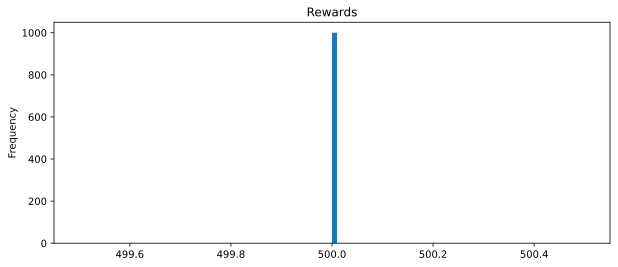

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

fig, ax = plt.subplots(figsize = (10, 4))
ax.set_title("Rewards")    
pd.Series(rewards).plot(kind='hist', bins=100)

plt.show()

## Let's see our agent in action 🎬

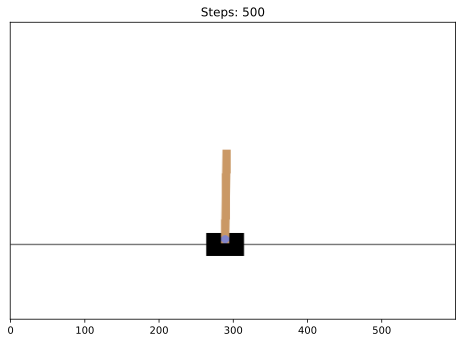

In [20]:
# Workaround for pygame error: "error: No available video device"
# See https://stackoverflow.com/questions/15933493/pygame-error-no-available-video-device?rq=1
# This is probably needed only for Linux
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"

from viz import show_video

show_video(agent, env, sleep_sec=0.01, seed=123)